In [72]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data


In [73]:
def make_data(rng, noise, shear):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr,
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(
        dx=dx,
        dy=dy,
    )
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale=scale).array

    # psf noise
    psf_noise= .001
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    im += rng.normal(scale=noise, size=im.shape)
    
    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    wt     = im*0 + 1.0/noise**2
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs

In [74]:
def analyze(rng, num_tests, noise_level):
    dlist = []
    data = []
    shear_true = [0.03, 0.00]
    x = []
    y = []
    for i in range(num_tests):
        print("data size = ", len(data))
        for j in range(100):
            obs = make_data(rng=rng, noise=noise_level[i], shear=shear_true)
            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
        data.append(np.hstack(dlist))
        print("noise = ", noise_level[i])
        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g1_1p= data[i]['g'][w_1p, 0].mean()
        g1_1m= data[i]['g'][w_1m, 0].mean()
        R11  = (g1_1p - g1_1m)/0.02
        s2n = data[i]['s2n'][w].mean()
        print ("s2n = ", s2n)
        g = data[i]['g'][w].mean(axis=0)
        shear= g / R11
        print("shear[0] = ", shear[0])
        x.append(s2n)
        y.append(shear[0])
    return x, y

In [75]:
rng = np.random.RandomState(1024)
# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

In [76]:
# simulate 100 galaxies
# and put them into a list
"""
obs_list1=[]
obs_list2=[]
obs_list3=[]
obs_list4=[]
obs_list5=[]

shear_true = [0.03, 0.00]

for i in range(100):
    _obs1 = make_data(rng=rng, noise=.001, shear=shear_true)
    obs_list1.append(_obs1)
    del _obs1
    
for i in range(100):
    _obs2 = make_data(rng=rng, noise=.005, shear=shear_true)
    obs_list2.append(_obs2)
    del _obs2

for i in range(100):
    _obs3 = make_data(rng=rng, noise=.0001, shear=shear_true)
    obs_list3.append(_obs3)
    del _obs3
    
for i in range(100):
    _obs4 = make_data(rng=rng, noise=.0005, shear=shear_true)
    obs_list4.append(_obs4)
    del _obs4
    
for i in range(100):
    _obs5 = make_data(rng=rng, noise=.05, shear=shear_true)
    obs_list5.append(_obs5)
    del _obs5
"""

'\nobs_list1=[]\nobs_list2=[]\nobs_list3=[]\nobs_list4=[]\nobs_list5=[]\n\nshear_true = [0.03, 0.00]\n\nfor i in range(100):\n    _obs1 = make_data(rng=rng, noise=.001, shear=shear_true)\n    obs_list1.append(_obs1)\n    del _obs1\n    \nfor i in range(100):\n    _obs2 = make_data(rng=rng, noise=.005, shear=shear_true)\n    obs_list2.append(_obs2)\n    del _obs2\n\nfor i in range(100):\n    _obs3 = make_data(rng=rng, noise=.0001, shear=shear_true)\n    obs_list3.append(_obs3)\n    del _obs3\n    \nfor i in range(100):\n    _obs4 = make_data(rng=rng, noise=.0005, shear=shear_true)\n    obs_list4.append(_obs4)\n    del _obs4\n    \nfor i in range(100):\n    _obs5 = make_data(rng=rng, noise=.05, shear=shear_true)\n    obs_list5.append(_obs5)\n    del _obs5\n'

data size =  0
noise =  0.001
s2n =  57.69624625576704
shear[0] =  0.034591929054781576
data size =  1
noise =  0.005
s2n =  34.62804035435029
shear[0] =  0.03280887777303023
data size =  2
noise =  0.0001
s2n =  215.7322741246871
shear[0] =  0.03146262643358368
data size =  3
noise =  0.0005
s2n =  190.30137036162134
shear[0] =  0.030761552709815364
data size =  4
noise =  1e-05
s2n =  1300.1603816644397
shear[0] =  0.030214635173690888


Text(0, 0.5, 'g_measured')

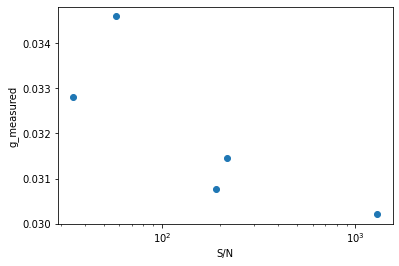

In [77]:
"""
%%time
dlist1 = []
dlist2 = []
dlist3 = []
dlist4 = []
dlist5 = []

for i in range(100):
    obs1 = obs_list1[i]
    resdict, obsdict = boot.go(obs1)
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist1.append(st)
        
for i in range(100):
    obs2 = obs_list2[i]
    resdict, obsdict = boot.go(obs2)
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist2.append(st)

for i in range(100):
    obs3 = obs_list3[i]
    resdict, obsdict = boot.go(obs3)
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist3.append(st)
        
for i in range(100):
    obs4 = obs_list4[i]
    resdict, obsdict = boot.go(obs4)
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist4.append(st)
        
for i in range(100):
    obs5 = obs_list5[i]
    resdict, obsdict = boot.go(obs5)
    for stype, sres in resdict.items():
        st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
        dlist5.append(st)
    
data1 = np.hstack(dlist1)
data2 = np.hstack(dlist2)
data3 = np.hstack(dlist3)
data4 = np.hstack(dlist4)
data5 = np.hstack(dlist5)
#print(data)


x = []
y = []

w1 = select(data=data1, shear_type='noshear')
w2 = select(data=data2, shear_type='noshear')
w3 = select(data=data3, shear_type='noshear')
w4 = select(data=data4, shear_type='noshear')
w5 = select(data=data5, shear_type='noshear')

w_1p1 = select(data=data1, shear_type='1p')
w_1m1 = select(data=data1, shear_type='1m')
w_1p2 = select(data=data2, shear_type='1p')
w_1m2 = select(data=data2, shear_type='1m')
w_1p3 = select(data=data3, shear_type='1p')
w_1m3 = select(data=data3, shear_type='1m')
w_1p4 = select(data=data4, shear_type='1p')
w_1m4 = select(data=data4, shear_type='1m')
w_1p5 = select(data=data5, shear_type='1p')
w_1m5 = select(data=data5, shear_type='1m')

g1_1p_1= data1['g'][w_1p1, 0].mean()
g1_1m_1= data1['g'][w_1m1, 0].mean()
R11_1  = (g1_1p_1 - g1_1m_1)/0.02
g1_1p_2= data2['g'][w_1p2, 0].mean()
g1_1m_2= data2['g'][w_1m2, 0].mean()
R11_2  = (g1_1p_2 - g1_1m_2)/0.02
g1_1p_3= data3['g'][w_1p3, 0].mean()
g1_1m_3= data3['g'][w_1m3, 0].mean()
R11_3  = (g1_1p_3 - g1_1m_3)/0.02
g1_1p_4= data4['g'][w_1p4, 0].mean()
g1_1m_4= data4['g'][w_1m4, 0].mean()
R11_4  = (g1_1p_4 - g1_1m_4)/0.02
g1_1p_5= data5['g'][w_1p5, 0].mean()
g1_1m_5= data5['g'][w_1m5, 0].mean()
R11_5  = (g1_1p_5 - g1_1m_5)/0.02




s2n_1 = data1['s2n'][w1].mean()
s2n_2 = data2['s2n'][w2].mean()
s2n_3 = data3['s2n'][w3].mean()
s2n_4 = data4['s2n'][w4].mean()
s2n_5 = data5['s2n'][w5].mean()

x.append(s2n_1)
x.append(s2n_2)
x.append(s2n_3)
x.append(s2n_4)
x.append(s2n_5)

g1 = data1['g'][w1].mean(axis=0)
g2 = data2['g'][w2].mean(axis=0)
g3 = data3['g'][w3].mean(axis=0)
g4 = data4['g'][w4].mean(axis=0)
g5 = data5['g'][w5].mean(axis=0)

shear1= g1 / R11_1
shear2= g2 / R11_2
shear3= g3 / R11_3
shear4= g4 / R11_4
shear5= g5 / R11_5


m1 = shear1[0]/shear_true[0]-1
c1 = shear1[1]
m2 = shear2[0]/shear_true[0]-1
c2 = shear2[1]
m3 = shear3[0]/shear_true[0]-1
c3 = shear3[1]
m4 = shear4[0]/shear_true[0]-1
c4 = shear4[1]
m5 = shear5[0]/shear_true[0]-1
c5 = shear5[1]



y.append(shear1[0])
y.append(shear2[0])
y.append(shear3[0])
y.append(shear4[0])
y.append(shear5[0])


for i in range(100):
    s2n = data['s2n'][i]
    x.append(s2n)
    
    m = shear[0]/shear_true[0]-1
    c = shear[1]
    g = data['g'][i, 0]
    #g = shear[0]
    
    g_meas = (1+m)*g + c
    y.append(g_meas)
    #s2n = data['s2n'][i]
    
    #x.append(s2n)
    #y.append(g_meas)
"""

#print(x)
#print(y)
#print(x, y)
# num_tests must = len(noise_arr)
noise_arr = [0.001, 0.005, 0.0001, 0.0005, 0.00001]
num_tests = 5
ans = analyze(rng, num_tests, noise_arr)
plt.scatter(ans[0], ans[1])
plt.xscale("log")
plt.xlabel("S/N")
plt.ylabel("g_measured")

In [78]:
"""
w = select(data=data, shear_type='noshear')
w_1p = select(data=data, shear_type='1p')
w_1m = select(data=data, shear_type='1m')

g    = data['g'][w].mean(axis=0)
gerr = data['g'][w].std(axis=0) / np.sqrt(w.size)
g1_1p= data['g'][w_1p, 0].mean()
g1_1m= data['g'][w_1m, 0].mean()
R11  = (g1_1p - g1_1m)/0.02


shear= g / R11
shear_err = gerr / R11

m    = shear[0]/shear_true[0]-1
merr = shear_err[0]/shear_true[0]

s2n  = data['s2n'][w].mean()

print('S/N: %g' % s2n)
print('R11: %g' % R11)
print('m: %g +/- %g (99.7%% conf)' % (m, merr*3))
print('c: %g +/- %g (99.7%% conf)' % (shear[1], shear_err[1]*3))
#g_meas = (1+m)g + c
"""

"\nw = select(data=data, shear_type='noshear')\nw_1p = select(data=data, shear_type='1p')\nw_1m = select(data=data, shear_type='1m')\n\ng    = data['g'][w].mean(axis=0)\ngerr = data['g'][w].std(axis=0) / np.sqrt(w.size)\ng1_1p= data['g'][w_1p, 0].mean()\ng1_1m= data['g'][w_1m, 0].mean()\nR11  = (g1_1p - g1_1m)/0.02\n\n\nshear= g / R11\nshear_err = gerr / R11\n\nm    = shear[0]/shear_true[0]-1\nmerr = shear_err[0]/shear_true[0]\n\ns2n  = data['s2n'][w].mean()\n\nprint('S/N: %g' % s2n)\nprint('R11: %g' % R11)\nprint('m: %g +/- %g (99.7%% conf)' % (m, merr*3))\nprint('c: %g +/- %g (99.7%% conf)' % (shear[1], shear_err[1]*3))\n#g_meas = (1+m)g + c\n"